### Outline

The goal of this notebook is to illustrate the full BLISS pipeline, briefly. We will identify several of the main data objects used along the way, but avoid mathematical intricacies and details of the training objective. Briefly, we'll have

1. Generation of synthetic data
2. Training of the encoder network
3. Validation/evaluation of the encoder network on held-out data (either simulated or real).

#### 1. Generation of synthetic data.

This would typically be done using something like ```bliss mode=generate``` from the command line. This calls the ```generate``` function within ```bliss/main.py```, using the default ```DictConfig``` object specified by the various ```.yaml``` files.

The code below loads the file ```m2_config.yaml``` from ```case_studies/dependent_tiling``` as a DictConfig for use by ```hydra```. You may have to change some absolute and relative paths to get this to load for you.

In [1]:
import sys
import os

In [2]:
os.getcwd()

'/home/declan/current/bliss/case_studies/redshift_estimation'

In [3]:
os.chdir('/home/declan/current/bliss')

In [4]:
from bliss.encoder.variational_dist import VariationalDistSpec, VariationalDist
from bliss.encoder.unconstrained_dists import UnconstrainedNormal
import torch
import numpy as np
from os import environ
from pathlib import Path
from hydra import initialize, compose
from hydra.utils import instantiate
import matplotlib.pyplot as plt
from omegaconf import DictConfig, OmegaConf
from bliss.catalog import TileCatalog

In [5]:
environ["BLISS_HOME"] = "/home/declan/current/bliss"
with initialize(config_path="../../case_studies/dependent_tiling", version_base=None):
    cfg = compose("m2_config", overrides={"surveys.sdss.load_image_data=true"})

In [6]:
type(cfg)

omegaconf.dictconfig.DictConfig

In [7]:
print(OmegaConf.to_yaml(cfg, resolve=False, sort_keys=False))

paths:
  root: ${oc.env:BLISS_HOME}
  data: ${paths.root}/data
  sdss: ${paths.data}/sdss
  decals: ${paths.data}/decals
  des: ${paths.data}/des
  dc2: ${paths.data}/dc2
  output: ${paths.root}/output
  pretrained_models: ${paths.data}/pretrained_models
prior:
  _target_: bliss.simulator.prior.CatalogPrior
  survey_bands:
  - u
  - g
  - r
  - i
  - z
  reference_band: 2
  star_color_model_path: ${simulator.survey.dir_path}/color_models/star_gmm_nmgy.pkl
  gal_color_model_path: ${simulator.survey.dir_path}/color_models/gal_gmm_nmgy.pkl
  n_tiles_h: 56
  n_tiles_w: 56
  tile_slen: 2
  batch_size: 32
  max_sources: 6
  mean_sources: 0.48
  min_sources: 0
  prob_galaxy: 0.0
  star_flux_exponent: 0.9859821185389767
  star_flux_truncation: 5685.588160703261
  star_flux_loc: -1.162430157551662
  star_flux_scale: 1.4137911256506595
  galaxy_flux_truncation: 1013
  galaxy_flux_exponent: 0.47
  galaxy_flux_scale: 0.6301037
  galaxy_flux_loc: 0.0
  galaxy_a_concentration: 0.39330758068481686
  

You can browse the above printouts to get a feel for how the config is structured. Our project will eventually add some configurables and we'll have our own config similar to the above.

The ```generate``` function from ```bliss/main.py``` takes arguments as

```
def generate(gen_cfg: DictConfig):
   ...

```

and so we can plug in a given ```DictConfig``` like the above to generate data. The true ```generate``` function is much more complex than what is given below, and helps cache previously simulated data to save time, etc. Our altered function below is used only for illustration purposes, where we'll generate a single batch of simulated data.

In [8]:
cfg.generate

{'n_image_files': 16, 'n_batches_per_file': 16, 'simulator': '${simulator}', 'cached_data_path': '/data/scratch/regier/m2', 'file_prefix': 'dataset'}

In [9]:
def generate(gen_cfg: DictConfig):
    simulated_dataset = instantiate(gen_cfg.simulator, num_workers=0)

    for _ in range(1):
        batch = simulated_dataset.get_batch()
        
    return batch

In [10]:
simulated_batch_of_data = generate(cfg.generate)

Note that the 'full' configurable has three main subconfigs: `cfg.generate, cfg.train, cfg.predict`. This just helps keep things more organized. We only passed `cfg.generate` to the ```generate``` function.

##### ***Running the above cell will take several minutes*** 

In [11]:
simulated_batch_of_data.keys()

dict_keys(['tile_catalog', 'images', 'background', 'deconvolution', 'psf_params'])

The simulated batch is a ```dict``` object. These can be stored to disk in some fashion that we won't worry about right now (see ```generate``` function in ```bliss/main.py```), as we'll just work with this single batch. Let's examine some of the objects.

In [12]:
tc = simulated_batch_of_data['tile_catalog']
tc.keys()

dict_keys(['locs', 'n_sources', 'source_type', 'galaxy_fluxes', 'galaxy_params', 'star_fluxes'])

In [13]:
tc['locs'].shape

torch.Size([32, 56, 56, 6, 2])

In [14]:
tc['n_sources'].shape

torch.Size([32, 56, 56])

In [15]:
tc['source_type'].shape

torch.Size([32, 56, 56, 6, 1])

In [16]:
tc['galaxy_fluxes'].shape

torch.Size([32, 56, 56, 6, 5])

In [17]:
tc['galaxy_params'].shape

torch.Size([32, 56, 56, 6, 6])

The first three dimensions of all these objects are 32 x 56 x 56. These numbers represent the following:
- 32 = number of synthetic (simulated) images
- 56 = number of tiles lengthwise
- 56 = number of tiles widthwise

BLISS operates by dividing a given images into *tiles* of a certain size. This can be thought of as parsing the image into bite-size pieces. The number of tiles and number of images in simulated batches are controllable from the config object, e.g. 

In [18]:
cfg.prior.batch_size, cfg.prior.n_tiles_h, cfg.prior.n_tiles_w

(32, 56, 56)

BLISS constrains the number of objects per tile to be between 0 and 5. Tiles are small enough (in terms of pixel size) to make this reasonable. Hence if we examine ```tc['n_sources']``` we see that this tensor specifies the number of sources for each tile in each image.

In [19]:
tc['n_sources'][0] #56 x 56 tensor telling us the number of sources in each tile for the first image.

tensor([[0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 3,  ..., 1, 0, 1],
        [0, 0, 0,  ..., 0, 0, 1],
        ...,
        [0, 1, 0,  ..., 0, 1, 0],
        [0, 0, 1,  ..., 0, 1, 0],
        [0, 1, 0,  ..., 0, 0, 1]])

In [20]:
tc['n_sources'].max(), tc['n_sources'].min()

(tensor(5), tensor(0))

Each object (or source) can be one of several different types. There are at most 5 sources per tile. Hence ```tc['source_type']``` has a per-tile shape of 5 x 1. For tile, this tells us the type of each source. If there are fewer than 5 sources, the extra information is discarded or masked somehow. This number 5 that is floating around all the other dimensions arises similarly from the fact that we have at most 5 sources per tile. We can gather from the shapes above that ```locs``` contains a 2d coordinate for each source; ```galaxy_fluxes``` contains 5 parameters for each source; ```galaxy_params``` contains 6 parameters for each source, etc. 

***All of the these are latent random variables $z$ that are used to generate the image. Given a tile catalog like the above, we have all the information necessary to generate synthetic images $x$. The inference problem is then to take an image $x$ and construct a distribution on all of these quantities $z$. In other words, given an image, we divide it into tiles and for each tile we aim to recover the number of sources, the type of each source, the locations of each, the fluxes for each, etc.***

Let's examine a sample synthetic image below.

In [21]:
ims = simulated_batch_of_data['images']

In [22]:
ims.shape

torch.Size([32, 5, 112, 112])

As expected, there are 32 images. The dimension 5 does not correspond to the number of sources per tile, but rather to the *photometric band* of each image, corresponding to u,g,r,i,z for SDSS data. Read more here: https://www.sdss4.org/instruments/camera/#Filters

Again, these are specified in the config:

In [23]:
cfg.prior.survey_bands

['u', 'g', 'r', 'i', 'z']

We gather that each image for each band is 112 x 112. Recalling that we have 56 x 56 tiles, this implie that each tile is 2x2. Again, this is specified in the config.

In [24]:
cfg.prior.tile_slen

2

Let's examine some simulated images.

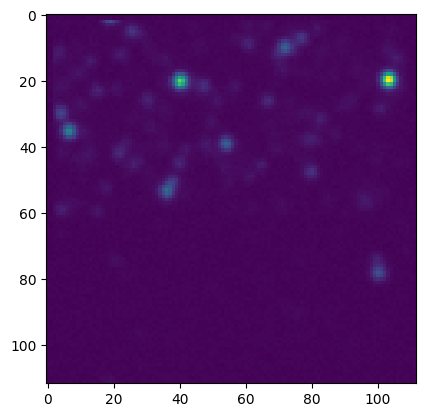

In [25]:
plt.imshow(ims[0][0]) #u-band for first of 32 images

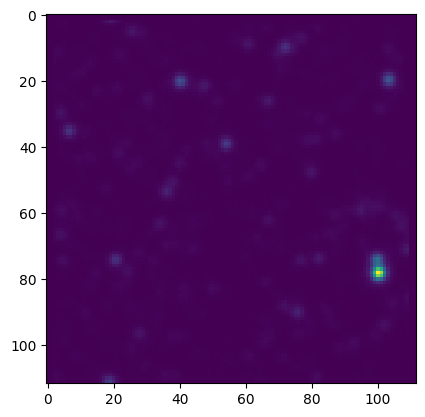

In [26]:
plt.imshow(ims[0][1]) #g-band for first of 32 images

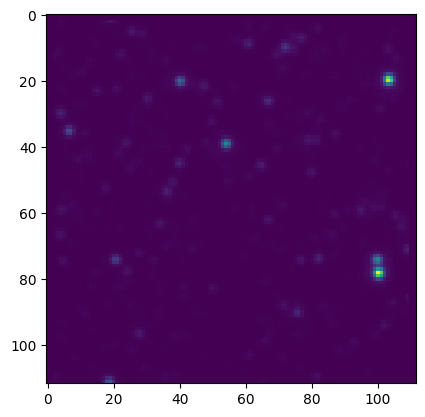

In [27]:
plt.imshow(ims[0][2]) #r-band for first of 32 images

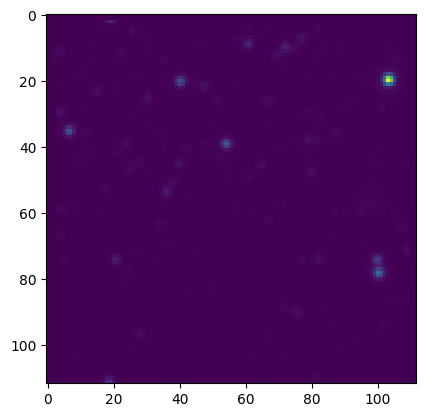

In [28]:
plt.imshow(ims[0][3]) #i-band for first of 32 images

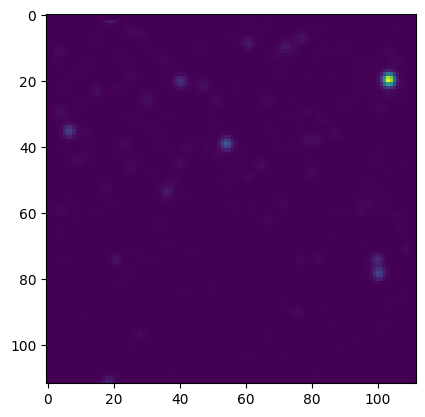

In [29]:
plt.imshow(ims[0][4]) #z-band for first of 32 images

We notice that some objects appear not to show up in some bands, or appear more faint in some bands than others. This is normal: objects emit light at different wavelengths, and so in some wavelength ranges (e.g. a particular band) an object may not appear to be visible at all.

We won't worry about the other latent variables for now (given again below). More detail on these can be explored on a project-by-project basis.

In [30]:
simulated_batch_of_data.keys()

dict_keys(['tile_catalog', 'images', 'background', 'deconvolution', 'psf_params'])

#### 2. Training the encoder

The encoder $q_\phi(z \mid x)$ learns a *variational distribution* on $z$ conditional on an observed $x$. We use machine learning and amortization to automate this process: given any $x$, we get a distribution on $z$ by putting $x$ through a neural network (whose parameters are $\phi$). For us, $z$ is a complex object, consisting of all the parameters in the tile catalog above (or more). 

The training objective is quite simple, and is given by

$$
\max_\phi \mathbb{E}_{p(z,x)} \log q_\phi(z \mid x)
$$

in other words, maximize the variational density across all $z,x$ from the generative model $p(z,x)$. For us, the generative model is given by 

$$
p(z,x) = p(z) p(x \mid x)
$$

where $p(z)$ is the prior, and $p(x \mid x)$ generats images from the prior. We won't focus much at all on $p(z \mid x)$. Rather, we'll focus on the prior, and we will alter the tile catalog $z$ (e.g., to include new parameters such as redshift). The information for the prior is again given by the config:

In [31]:
print(OmegaConf.to_yaml(cfg.prior, resolve=False, sort_keys=False))

_target_: bliss.simulator.prior.CatalogPrior
survey_bands:
- u
- g
- r
- i
- z
reference_band: 2
star_color_model_path: /home/declan/current/bliss/data/sdss/color_models/star_gmm_nmgy.pkl
gal_color_model_path: /home/declan/current/bliss/data/sdss/color_models/gal_gmm_nmgy.pkl
n_tiles_h: 56
n_tiles_w: 56
tile_slen: 2
batch_size: 32
max_sources: 6
mean_sources: 0.48
min_sources: 0
prob_galaxy: 0.0
star_flux_exponent: 0.9859821185389767
star_flux_truncation: 5685.588160703261
star_flux_loc: -1.162430157551662
star_flux_scale: 1.4137911256506595
galaxy_flux_truncation: 1013
galaxy_flux_exponent: 0.47
galaxy_flux_scale: 0.6301037
galaxy_flux_loc: 0.0
galaxy_a_concentration: 0.39330758068481686
galaxy_a_loc: 0.8371888967872619
galaxy_a_scale: 4.432725319432478
galaxy_a_bd_ratio: 2.0



In [32]:
cfg.prior.galaxy_a_bd_ratio

2.0

These numbers can be considered as hyperparameters that define the prior. We don't actually need to infer these numbers precisely. Rather, for a tile catalog $z$ sampled from the prior $p(z)$, we want to infer $z$ given its corresponding image $x$.

Training is performed using the ```train``` function from ```bliss/main.py```. As above, we pass `cfg.train` to the `train` function, which is reproduced below (with some lines omitted).

In [33]:
def train(train_cfg: DictConfig):
    # setup seed
    pl.seed_everything(train_cfg.seed)

    # setup dataset, encoder, and trainer
    dataset = instantiate(train_cfg.data_source)
    encoder = instantiate(train_cfg.encoder)
    trainer = instantiate(train_cfg.trainer)

    # train!
    trainer.fit(encoder, datamodule=dataset)


Let's examine the three main objects that the training procedure evidently uses: a dataset, an encoder, and a trainer. Again, these are all specified by the config, and instatiated in the train function above.

In [34]:
cfg.train.data_source

{'_target_': 'bliss.simulator.simulated_dataset.CachedSimulatedDataset', 'batch_size': 23, 'splits': '0:80/80:90/90:100', 'num_workers': 0, 'cached_data_path': '/data/scratch/regier/m2', 'file_prefix': '${generate.file_prefix}'}

We see that the data-source is a cached dataset. In other words, lots of saved $z,x$ pairs from the generative model $p(z,x)$ that have been written to disk previously. These are used to fit the objective function approximately, e.g.

$$
\max_\phi \frac{1}{n} \sum_{i=1}^n \log q_\phi(z_i \mid x_i)
$$

where $n$ is the number of cached $z,x$ pairs that have been saved. For us, we only have one pair of $z,x$. We'll evidently need to convert these to type `CachedSimulatedDataset` to fit in with the framework.

In [35]:
cfg.train.encoder

{'_target_': 'bliss.encoder.encoder.Encoder', 'survey_bands': ['u', 'g', 'r', 'i', 'z'], 'tile_slen': 2, 'tiles_to_crop': 1, 'min_flux_threshold': 0.9419, 'optimizer_params': {'lr': 0.001}, 'scheduler_params': {'milestones': [32], 'gamma': 0.1}, 'image_normalizer': {'_target_': 'bliss.encoder.image_normalizer.ImageNormalizer', 'bands': [2], 'include_original': False, 'use_deconv_channel': False, 'concat_psf_params': False, 'num_psf_params': 6, 'log_transform_stdevs': [-3, 0, 1, 3], 'use_clahe': True, 'clahe_min_stdev': 200}, 'vd_spec': {'_target_': 'bliss.encoder.variational_dist.VariationalDistSpec', 'survey_bands': '${encoder.survey_bands}', 'tile_slen': '${encoder.tile_slen}'}, 'matcher': {'_target_': 'bliss.encoder.metrics.CatalogMatcher', 'dist_slack': 0.5, 'mag_slack': 0.5, 'mag_band': 2}, 'metrics': {'_target_': 'torchmetrics.MetricCollection', 'metrics': [{'_target_': 'bliss.encoder.metrics.DetectionPerformance', 'mag_bin_cutoffs': [19, 19.4, 19.8, 20.2, 20.6, 21, 21.4, 21.8, 2

All these configurables will instantiate an `Encoder` object. This object will perform the function described above, i.e. given an image $x$ it will give us a distribution on the tile catalog $z$. 

In [36]:
cfg.train.trainer

{'_target_': 'pytorch_lightning.Trainer', 'logger': {'_target_': 'pytorch_lightning.loggers.TensorBoardLogger', 'save_dir': '${paths.output}', 'name': None, 'version': None, 'default_hp_metric': False}, 'callbacks': [{'_target_': 'pytorch_lightning.callbacks.ModelCheckpoint', 'filename': 'best_encoder', 'save_top_k': 1, 'verbose': True, 'monitor': 'val/_loss', 'mode': 'min', 'save_on_train_epoch_end': False, 'auto_insert_metric_name': False}, {'_target_': 'pytorch_lightning.callbacks.early_stopping.EarlyStopping', 'monitor': 'val/_loss', 'mode': 'min', 'patience': 5}], 'reload_dataloaders_every_n_epochs': 0, 'check_val_every_n_epoch': 1, 'log_every_n_steps': 10, 'min_epochs': 1, 'max_epochs': 50, 'accelerator': 'gpu', 'devices': 1, 'precision': '16-mixed'}

The trainer evidently wraps up the training procedure with lots of information about logging, checkpoints, metrics, etc. We won't worry so much about this for now.

Our simplified version of training for illustrative purposes will try to unwrap some of the abstraction above. Let's first instantiate the encodeer so we can examine it.

In [37]:
encoder = instantiate(cfg.train.encoder)
encoder

Encoder(
  (image_normalizer): ImageNormalizer()
  (vd_spec): VariationalDistSpec()
  (mode_metrics): MetricCollection(
    (DetectionPerformance): DetectionPerformance()
  )
  (sample_metrics): MetricCollection(
    (DetectionPerformance): DetectionPerformance()
  )
  (features_net): FeaturesNet(
    (preprocess3d): Sequential(
      (0): Conv3d(1, 64, kernel_size=(6, 5, 5), stride=(1, 1, 1), padding=(0, 2, 2))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
    )
    (backbone): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (activation): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): ConvBlock(
          (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
          (bn): BatchNorm2d(64, eps=0.

If you're familiar with PyTorch, you'll recognize that the encoder essentially is a huge neural network as described above, with some fancy preprocessing, normalization, metrics, etc. Let's examine some of the Encoder object's methods, which are reproduced below.

```
def _single_detection_nll(self, target_cat, pred):
        marginal_loss = pred["marginal"].compute_nll(target_cat)

        if not self.use_checkerboard:
            return marginal_loss

        white_loss = pred["white"].compute_nll(target_cat)
        white_loss_mask = 1 - pred["white_history_mask"]
        white_loss *= white_loss_mask

        black_loss = pred["black"].compute_nll(target_cat)
        black_loss_mask = pred["white_history_mask"]
        black_loss *= black_loss_mask

        # we divide by two because we score two predictions for each tile
        return (marginal_loss + white_loss + black_loss) / 2

    def _double_detection_nll(self, target_cat1, target_cat, pred):
        target_cat2 = target_cat.get_brightest_sources_per_tile(band=2, exclude_num=1)

        nll_marginal_z1 = self._single_detection_nll(target_cat1, pred)
        nll_cond_z2 = pred["second"].compute_nll(target_cat2)
        nll_marginal_z2 = self._single_detection_nll(target_cat2, pred)
        nll_cond_z1 = pred["second"].compute_nll(target_cat1)

        none_mask = target_cat.n_sources == 0
        loss0 = nll_marginal_z1 * none_mask

        one_mask = target_cat.n_sources == 1
        loss1 = (nll_marginal_z1 + nll_cond_z2) * one_mask

        two_mask = target_cat.n_sources >= 2
        loss2a = nll_marginal_z1 + nll_cond_z2
        loss2b = nll_marginal_z2 + nll_cond_z1
        lse_stack = torch.stack([loss2a, loss2b], dim=-1)
        loss2_unmasked = -torch.logsumexp(-lse_stack, dim=-1)
        loss2 = loss2_unmasked * two_mask

        return loss0 + loss1 + loss2
```

Here, NLL stands for negative log likelihood, and for us this corresponds to $-\log q_\phi(z \mid x)$. We try to minimize this quantity, equivalent to maximizing the negative of it as we formulated above. Let's compute the NLL loss for the encoder. This should be poor because the encoder has been initialized only, not trained at all. The following code snippets are adapated from the `_compute_loss` function of the `Encoder` class in `bliss/encoder/encoder.py`.

In [38]:
batch = simulated_batch_of_data #renaming to something shorter
batch_size = batch["images"].size(0)
target_cat = TileCatalog(encoder.tile_slen, batch["tile_catalog"])

In [39]:
target_cat

TileCatalog(32 x 56 x 56)

The object `target_cat` is the "target catalog" of interest. It's of type TileCatalog that we create from the simulated batch.

In [41]:
# filter out undetectable sources
target_cat = target_cat.filter_tile_catalog_by_flux(min_flux=encoder.min_flux_threshold)

# make predictions/inferences
target_cat1 = target_cat.get_brightest_sources_per_tile(band=2, exclude_num=0)
truth_callback = lambda _: target_cat1
pred = encoder.infer(batch, truth_callback)

The above code performs some preprocessing on a per-tile basis to eliminate dim objects, etc. We don't need to understand all the details right now. The `infer` method of the `Encoder` object on the last line operates directly on the images of the batch i.e. `batch['images']`. It is a complex method that splits the image into tiles that are designated as white or black in a 'checkerboard' scheme --- this scheme helps with detection of objects at tile boundaries, which is a complex problem in its own right. We don't really need to understand the details of how all of this works for now. We do want to at least understand the form of the resulting object, which is stored in variable `pred`.

In [42]:
pred.keys()

dict_keys(['x_features', 'marginal', 'history_cat', 'white_history_mask', 'white', 'black', 'second'])

In [44]:
pred['marginal']

VariationalDist()

The resulting `VariationalDist` will be used to compute

$$
- \log q_\phi(z \mid x).
$$

Recall $z$ is the `target_cat` of type `TileCatalog`. Because we're generating synthetic data, the latent variable $z$ is not hidden, but known. The $x$ is given by the images from `batch['images']`, and these are operated on by the `infer` method of the encoder. The resulting computations yield the objects in `pred.keys()` above, which can be used to compute $-\log q_\phi(z \mid x)$ for this particular data batch. Rather than using the functions `_single_detection_nll` and `_double_detection_nll`, we could use the `compute_nll` method of the `VariationalDist` class. We'll do this for ease here.

In [45]:
loss = pred['marginal'].compute_nll(target_cat1)

In [46]:
loss.shape

torch.Size([32, 56, 56])

In [47]:
loss.mean()

tensor(16.8119, grad_fn=<MeanBackward0>)

Loss is evidently computed on a per-image per-tile basis. We'll average across all of these because they all deserve equal weighting in our toy setup here. Now that we've illustrated how to compute the loss, let's wrap this all into a training loop to fit the encoder. We'll fit by optimizing the parameters directly rather than wrapping the procedure into a PyTorch Lightning routine as is done in the true BLISS code. 

This is extremely simplistic: we have a single batch of data $z,x$ that we generated above.  Nevertheless, in the training loop below, we still redefine/recompute `pred` and the target catalogs. In a true training procedure with many different batches of images, this would need to be done within the loop because we'll have a different batch of images every time.

***Cell below runs very slow because all CPU. True codebase is optimized to GPU. Naive use of GPU below will lead to out of memory error.***

In [53]:
niter = 300
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)
for i in range(niter):
    # Many of the lines below are redundant because we have a single batch
    # so quantities don't change.
    
    target_cat = TileCatalog(encoder.tile_slen, batch["tile_catalog"])
    # filter out undetectable sources
    if encoder.min_flux_threshold > 0:
        target_cat = target_cat.filter_tile_catalog_by_flux(min_flux=encoder.min_flux_threshold)

    # make predictions/inferences
    target_cat1 = target_cat.get_brightest_sources_per_tile(band=2, exclude_num=0)
    truth_callback = lambda _: target_cat1
    pred = encoder.infer(batch, truth_callback)
    
    # Main gradient step code
    optimizer.zero_grad()
    loss = loss = pred['marginal'].compute_nll(target_cat1).mean()
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        print('Iteration {}: Loss {}'.format(i, loss.item()))
    

Iteration 0: Loss 16.811948776245117
Iteration 10: Loss 6.598885536193848
Iteration 20: Loss 5.9178547859191895
Iteration 30: Loss 5.234957218170166
Iteration 40: Loss 4.901239395141602
Iteration 50: Loss 4.73112154006958
Iteration 60: Loss 4.614767551422119
Iteration 70: Loss 4.516098499298096
Iteration 80: Loss 4.427545547485352
Iteration 90: Loss 4.342630386352539
Iteration 100: Loss 4.261025905609131
Iteration 110: Loss 4.1851487159729
Iteration 120: Loss 4.108051776885986
Iteration 130: Loss 4.046842098236084
Iteration 140: Loss 3.957535982131958


KeyboardInterrupt: 

The training procedure above is very rough: there's no learning rate tuning, scheduling, etc., and we don't run fitting procedure all the way to convergence due to time constraints. Nevertheless, this is enough to get a feel for how fitting the encoder should generally go. In actuality, however, a lot of this will be abstracted away within PyTorch lightning procedures.

We want to see how the encoder is doing. Recall we just have a single data pair $z,x$ that we've been training with. It's a reasonable expectation that with enough training time our encoder should learn to output the correct $z$ given $x$ as an input. Let's check it out. We do this by using the `sample` method of the encoder. We'll simply take the posterior mode for now, i.e. the mode of the distribution $q_\phi(z \mid x)$, but we could generate more diverse samples from the actual distribution if desired.

In [54]:
posterior_mode = encoder.sample(batch, use_mode=True)

In [55]:
type(posterior_mode)

bliss.catalog.TileCatalog

In [56]:
vars(posterior_mode).keys()

dict_keys(['tile_slen', 'locs', 'n_sources', 'batch_size', 'n_tiles_h', 'n_tiles_w', 'max_sources', 'data'])

Let's compare the posterior model to the true target catalog $z$, which is the variable `target_cat` after wrapping up in this object.

In [57]:
posterior_mode.n_sources.shape, target_cat.n_sources.shape

(torch.Size([32, 54, 54]), torch.Size([32, 56, 56]))

BLISS usually omits border tiles. We'll want to do the same when we look at the target catalog for evaluation.

In [58]:
posterior_mode.n_sources.shape, target_cat.n_sources[:,1:-1,1:-1, ...].shape

(torch.Size([32, 54, 54]), torch.Size([32, 54, 54]))

In [59]:
1.-(posterior_mode.n_sources != target_cat.n_sources[:,1:-1,1:-1, ...]).sum()/(32*54*54)

tensor(0.5619)

The line above tells use that the posterior mode has the correct number of sources in about 56% of tiles across the 32 images in our batch. This number would be much higher if we trained longer. Note that the variational distribution constrains us to have at most 2 sources per tile, so it's not surprising that some are wrong.

In [60]:
1.-(torch.abs(posterior_mode.n_sources - target_cat.n_sources[:,1:-1,1:-1, ...]) > 1).sum()/(32*54*54)

tensor(0.9394)

The line above tells us that in 94% of tiles in our 32 images, the number of sources detected differs from the true number of sources by no more than 1. In other words, even when the number of sources is wrong, it's usually off by no more than 1, calling mistaking 3 sources for 2, for example.

We can see if locations look approximately correct. Let's just look at a single tile, the first tile of the first image. Recall we need to omit the border tiles from the target catalog.

In [61]:
posterior_mode.locs.shape, target_cat.locs.shape

(torch.Size([32, 54, 54, 2, 2]), torch.Size([32, 56, 56, 6, 2]))

In [62]:
posterior_mode.locs[0][0][0]

tensor([[0.5239, 0.4951],
        [0.4982, 0.4801]], grad_fn=<SelectBackward0>)

In [63]:
target_cat.locs[:,1:-1,1:-1,...][0][0][0]

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])

In [64]:
target_cat.n_sources[:,1:-1,1:-1, ...][0][0][0]

tensor(0)

In [65]:
posterior_mode.n_sources[0][0][0]

tensor(1)

The true catalog says there's no sources in this particular tile, hence the coordinates for all (at most 5) potential sources are zeroed out. It looks initially like the posterior mode thinks there's two sources, because these coordinates are non-zero. However, if we check the n_sources attribute the number of sources is actually predicted to be 1. This is a quirk of the variational distribution: in the calculation of the NLL, we only account for the number of sources detected. If zero are detected and there truly are zero, for example, the locations don't factor into the NLL.

In [80]:
target_cat.n_sources[:,1:-1,1:-1, ...][0][1][-10]

tensor(1)

In [81]:
posterior_mode.n_sources[0][1][-10]

tensor(0)

Now we found a tile with 2 sources. Let's look at locations for these.

In [ ]:
target_cat.locs[:,1:-1,1:-1,...][0][2][-1]

In [ ]:
posterior_mode.locs[0][2][-1]

Not particularly close, suggesting maybe more training is needed. Let's find a tile where we're a bit closer.

In [ ]:
target_cat.n_sources[:,1:-1,1:-1, ...][-1][-1][0]

In [ ]:
posterior_mode.n_sources[-1][-1][0]

In [ ]:
target_cat.locs[:,1:-1,1:-1,...][-1][-1][0]

In [ ]:
posterior_mode.locs[-1][-1][0]

We detected one source in this tile and were correct: it's located at 0.7778,.9750. We predict it to be at .7026, .9352 which is kind of close, but still would ideally be better (remember the second line is ignored because we predict only a single source).